In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import datetime as dt


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# section 1 - loading data + cleaning duplicates

In [3]:
df = pd.read_csv('/Users/alex/Downloads/data_challenge_churn.csv', parse_dates=True)


In [4]:
dataSize = df.shape
print(dataSize)

(30313, 8)


In [5]:
df.head()

,customer_id,channel,geo,start_date,end_date,carrier,profession,cancellation_reason
0,d26f427100f022022014ee543e7fa0e8,affiliation,CA,2018-05-22,2019-05-22,2,1000,NaN
1,ed62654168d10e645bd9d322e8f3d04b,affiliation,NY,2017-09-28,2018-09-28,2,1000,NaN
2,2fdb93954bea383d5d9f04953131fa5a,support,TX,2018-04-20,2019-04-20,7,5009,NaN
3,97244decfbab241392b92c09d699275c,sem,OH,2018-02-05,2019-02-05,3,3000,NaN
4,700bfab23906fc29bd7352ebaf368a08,email,MO,2018-03-13,2018-07-06,7,100001,I had a short-term need for insurance that has...


In [6]:
1-(pd.isnull(df['cancellation_reason']).sum()) / dataSize[0]

0.22043347738593999

In [7]:
pd.isnull(df).sum()

customer_id                0
channel                   44
geo                        0
start_date                 0
end_date                   0
carrier                    0
profession                 0
cancellation_reason    23631
dtype: int64

In [8]:
df = df.drop_duplicates()

In [9]:
dataSize = df.shape
print(dataSize)

(29658, 8)


In [10]:
df['end_date_parsed'] = pd.to_datetime(df['end_date'])
df['start_date_parsed'] = pd.to_datetime(df['start_date'])

df['days_from_policy_start'] = (df['end_date_parsed'] - df['start_date_parsed']).dt.days

In [11]:
df.head()

,customer_id,channel,geo,start_date,end_date,carrier,profession,cancellation_reason,end_date_parsed,start_date_parsed,days_from_policy_start
0,d26f427100f022022014ee543e7fa0e8,affiliation,CA,2018-05-22,2019-05-22,2,1000,NaN,2019-05-22,2018-05-22,365
1,ed62654168d10e645bd9d322e8f3d04b,affiliation,NY,2017-09-28,2018-09-28,2,1000,NaN,2018-09-28,2017-09-28,365
2,2fdb93954bea383d5d9f04953131fa5a,support,TX,2018-04-20,2019-04-20,7,5009,NaN,2019-04-20,2018-04-20,365
3,97244decfbab241392b92c09d699275c,sem,OH,2018-02-05,2019-02-05,3,3000,NaN,2019-02-05,2018-02-05,365
4,700bfab23906fc29bd7352ebaf368a08,email,MO,2018-03-13,2018-07-06,7,100001,I had a short-term need for insurance that has...,2018-07-06,2018-03-13,115


In [12]:
categorical = ['channel','geo','carrier','profession','cancellation_reason']
numrical = ['days_from_policy_start']

# Data exploration

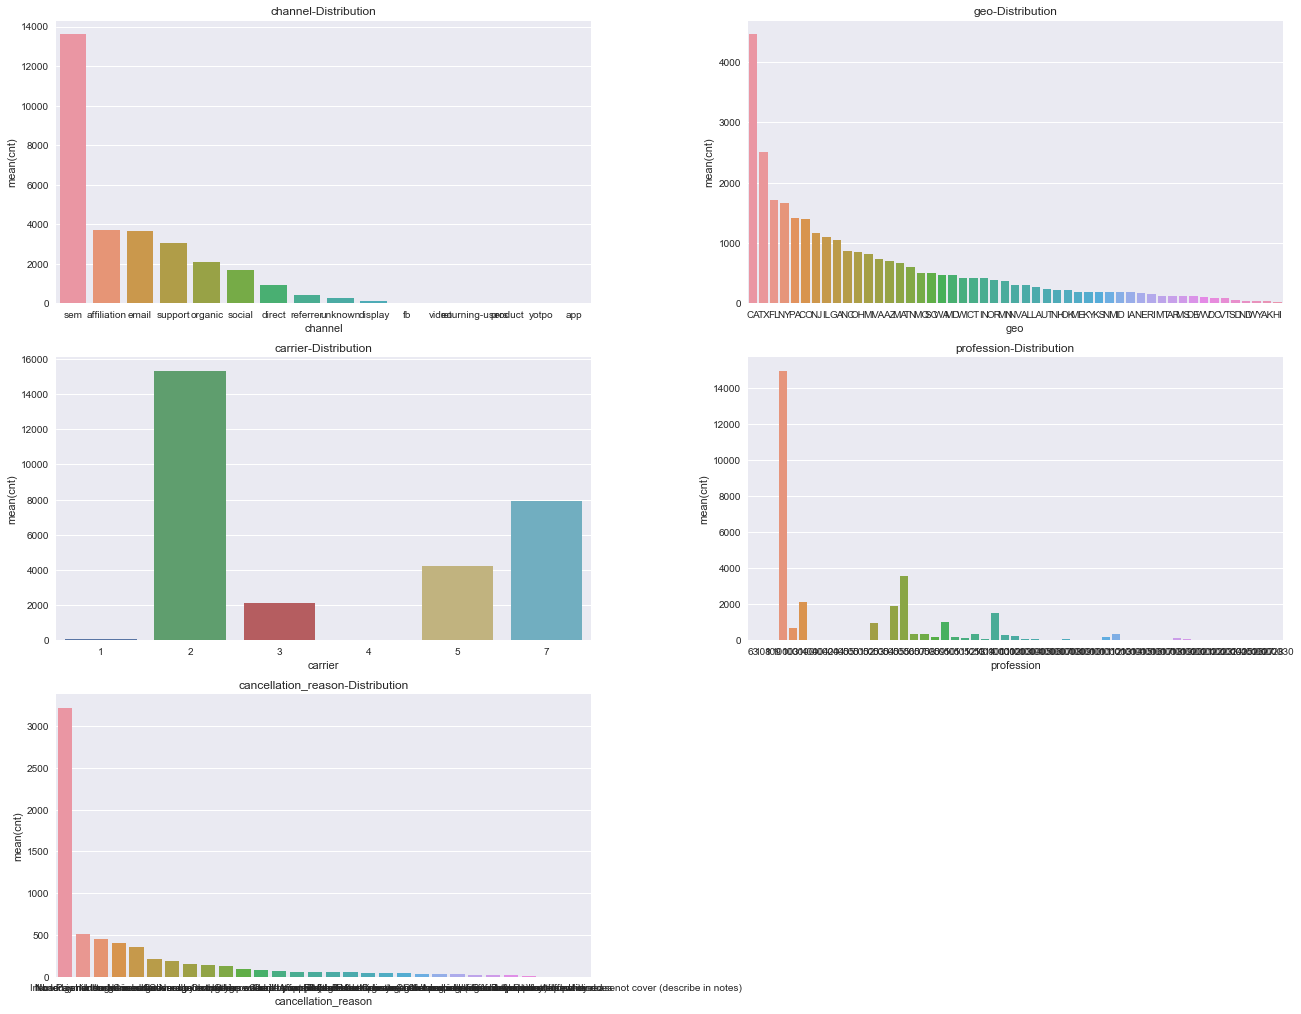

In [13]:
i=1
plt.figure(figsize=(18,14))
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'customer_id':'count'})\
    .reset_index().rename(columns={'customer_id': 'cnt'}).sort_values(['cnt'],ascending=False)
    plt.subplot(3,2,i)
    sns.barplot(df_grouped[dim],df_grouped['cnt'])
    plt.title('{}-Distribution'.format(dim))
#     if dim in ['customer_device_model','expert_id']:
#         plt.xticks([])
#     plt.xticks(rotation=60)
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [14]:
df_filtered = df
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'customer_id':'count'})\
    .reset_index().rename(columns={'customer_id': dim+'_cnt'})
    df_grouped[dim+'_ratio'] = df_grouped[dim+'_cnt']/dataSize[0]
    df_filtered = pd.merge(df_filtered,df_grouped, how = 'left', on = dim)


In [15]:
def is_minority(dim,ratio,threshold):
    if ratio<= threshold:
        return 'minority'
    else:
        return dim

In [16]:
for dim in categorical:
    df_filtered[dim] = df_filtered.apply(lambda row: is_minority(row[dim],row[dim+'_ratio'],0.005),axis=1)

In [17]:
def calculateRate(x,y):
    output = x/y
    return output

def is_churned(days_in_service):
    if days_in_service<365:
        return 1
    else:
        return 0

In [18]:
df['churned'] = df.apply(lambda row: is_churned(row['days_from_policy_start']) ,axis=1)

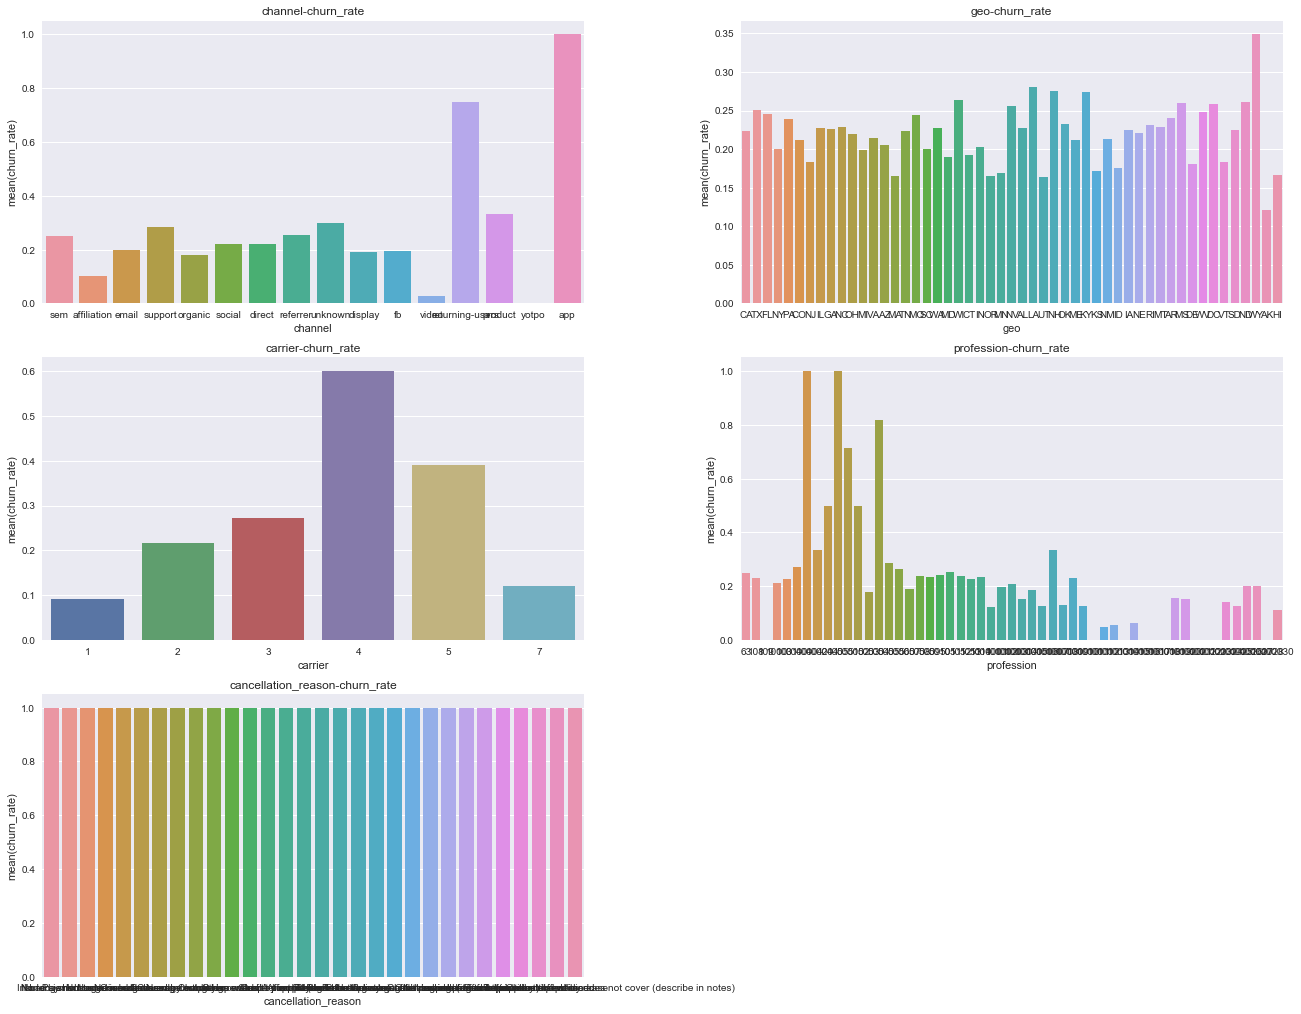

In [19]:
i=1
plt.figure(figsize=(18,14))
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'customer_id':'count', 'churned':'sum'})\
    .reset_index().rename(columns={'customer_id': 'cnt','churned':'sum'}).sort_values(['cnt'],ascending=False)
    df_grouped['churn_rate'] = df_grouped.apply(lambda row: calculateRate(row['sum'],row['cnt']),axis=1)
    plt.subplot(3,2,i)
    sns.barplot(df_grouped[dim],df_grouped['churn_rate'])
    plt.title('{}-churn_rate'.format(dim))
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

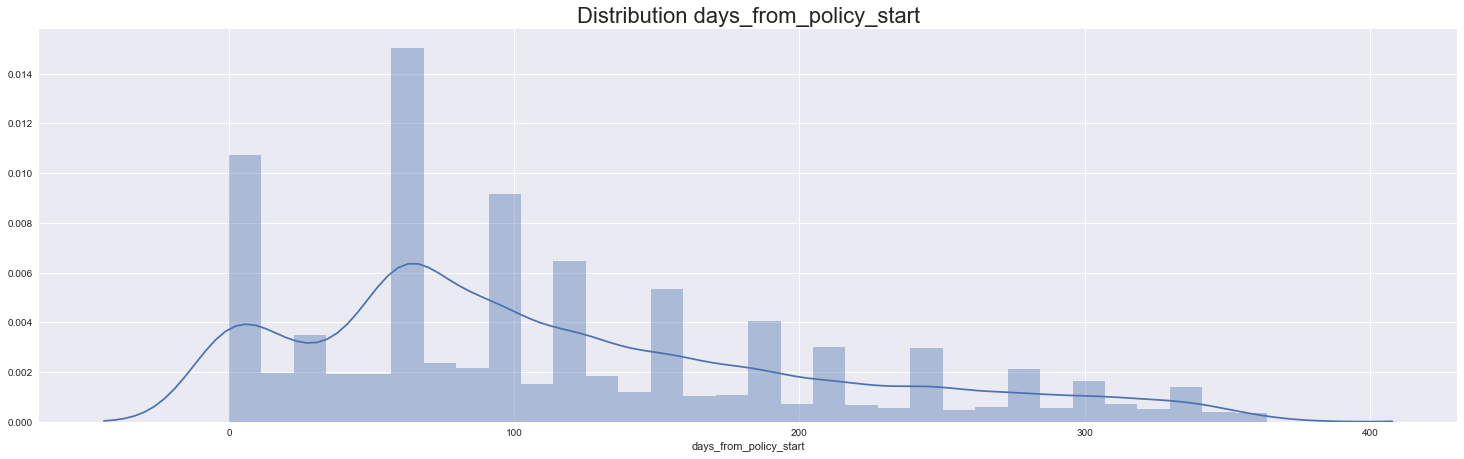

In [20]:
i=1
df_only_churned = df[df['churned']==1]
plt.figure(figsize=(40,60))
for dim in numrical:
    plt.subplot(10,2,i)
    sns.distplot(df_only_churned[dim])
    plt.title('Distribution '+dim, fontsize=22)
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [21]:
cols_of_intreset = ['channel','geo','carrier','profession']


In [22]:
df = df.reindex(columns=[*df.columns.tolist(),'month_1, month_2','month_3', 'month_4' ,'month_5', 'month_6' ,
                    'month_7' , 'month_8', 'month_9', 'month_10','month_11', 'month_12'],fill_value=0)

In [23]:
df.head()

,customer_id,channel,geo,start_date,end_date,carrier,profession,cancellation_reason,end_date_parsed,start_date_parsed,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,d26f427100f022022014ee543e7fa0e8,affiliation,CA,2018-05-22,2019-05-22,2,1000,NaN,2019-05-22,2018-05-22,...,0,0,0,0,0,0,0,0,0,0
1,ed62654168d10e645bd9d322e8f3d04b,affiliation,NY,2017-09-28,2018-09-28,2,1000,NaN,2018-09-28,2017-09-28,...,0,0,0,0,0,0,0,0,0,0
2,2fdb93954bea383d5d9f04953131fa5a,support,TX,2018-04-20,2019-04-20,7,5009,NaN,2019-04-20,2018-04-20,...,0,0,0,0,0,0,0,0,0,0
3,97244decfbab241392b92c09d699275c,sem,OH,2018-02-05,2019-02-05,3,3000,NaN,2019-02-05,2018-02-05,...,0,0,0,0,0,0,0,0,0,0
4,700bfab23906fc29bd7352ebaf368a08,email,MO,2018-03-13,2018-07-06,7,100001,I had a short-term need for insurance that has...,2018-07-06,2018-03-13,...,0,0,0,0,0,0,0,0,0,0


# Generating labels

In [24]:
def is_bigger_than(num1,col_val):
    if num1<=col_val:
        return 1
    else:
        return 0

In [25]:
label_cols = ['month_1', 'month_2','month_3', 'month_4' ,'month_5', 
          'month_6' ,'month_7' , 'month_8', 'month_9', 'month_10','month_11', 'month_12']

In [26]:
cols_to_drop = ['customer_id','channel','geo','carrier','profession','cancellation_reason',
               'end_date_parsed','start_date_parsed', 'days_from_policy_start', 'churned']

In [27]:
for month_col in label_cols:
    s,m = month_col.split('_')
    df[month_col] = df.apply(lambda row: is_bigger_than(round(row['days_from_policy_start']/30.4,0) + 1,int(m)),axis=1)

In [28]:
df.head()

,customer_id,channel,geo,start_date,end_date,carrier,profession,cancellation_reason,end_date_parsed,start_date_parsed,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,month_1,month_2
0,d26f427100f022022014ee543e7fa0e8,affiliation,CA,2018-05-22,2019-05-22,2,1000,NaN,2019-05-22,2018-05-22,...,0,0,0,0,0,0,0,0,0,0
1,ed62654168d10e645bd9d322e8f3d04b,affiliation,NY,2017-09-28,2018-09-28,2,1000,NaN,2018-09-28,2017-09-28,...,0,0,0,0,0,0,0,0,0,0
2,2fdb93954bea383d5d9f04953131fa5a,support,TX,2018-04-20,2019-04-20,7,5009,NaN,2019-04-20,2018-04-20,...,0,0,0,0,0,0,0,0,0,0
3,97244decfbab241392b92c09d699275c,sem,OH,2018-02-05,2019-02-05,3,3000,NaN,2019-02-05,2018-02-05,...,0,0,0,0,0,0,0,0,0,0
4,700bfab23906fc29bd7352ebaf368a08,email,MO,2018-03-13,2018-07-06,7,100001,I had a short-term need for insurance that has...,2018-07-06,2018-03-13,...,1,1,1,1,1,1,1,1,0,0


In [31]:
dataset = pd.get_dummies(df[cols_of_intreset  + label_cols], 
                         prefix=cols_of_intreset, 
                         columns=cols_of_intreset)

In [32]:
dataset.shape

(29658, 138)

# Build model + evaluation 

In [33]:
from sklearn.datasets import make_multilabel_classification
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.drop(label_cols,1), 
                                                    dataset[label_cols], 
                                                    test_size=0.3,
                                                    random_state=30)



In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import precision_recall_curve, average_precision_score


In [ ]:
def logistic_hyper_params(param_grid, x_train, y_train, x_test, y_test, verbose=1):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import expon
    model = LogisticRegression()
    c_distribution = expon(scale=1)
    param_grid_random = {'C': c_distribution, 'penalty': ['l1', 'l2']}
    randomsearch = RandomizedSearchCV(model, param_grid_random, n_iter=40, n_jobs=-1, verbose=1, scoring = 'roc_auc')
    rand_search_train = randomsearch.fit(x_train, y_train)
    return rand_search_train

**Processing month_1 comments...**
Test accuracy is 0.9722409530231513
Test AUC is 0.7117863793331796
Test Calibration Ratio: 0.9578451500196218


**Processing month_2 comments...**
Test accuracy is 0.9559451562148797
Test AUC is 0.673601947244922
Test Calibration Ratio: 0.94787128610582


**Processing month_3 comments...**
Test accuracy is 0.9106540795684424
Test AUC is 0.649247075972328
Test Calibration Ratio: 0.9502931753358153


**Processing month_4 comments...**
Test accuracy is 0.8783996403686222
Test AUC is 0.6461813721131306
Test Calibration Ratio: 0.9724742468476769


**Processing month_5 comments...**
Test accuracy is 0.8553607552258935
Test AUC is 0.6370116474570555
Test Calibration Ratio: 0.97362676057659


**Processing month_6 comments...**
Test accuracy is 0.8360305686671162
Test AUC is 0.6408701210789034
Test Calibration Ratio: 0.9870314051948833


**Processing month_7 comments...**
Test accuracy is 0.8242301640818162
Test AUC is 0.6447195815470455
Test Calibration Ratio

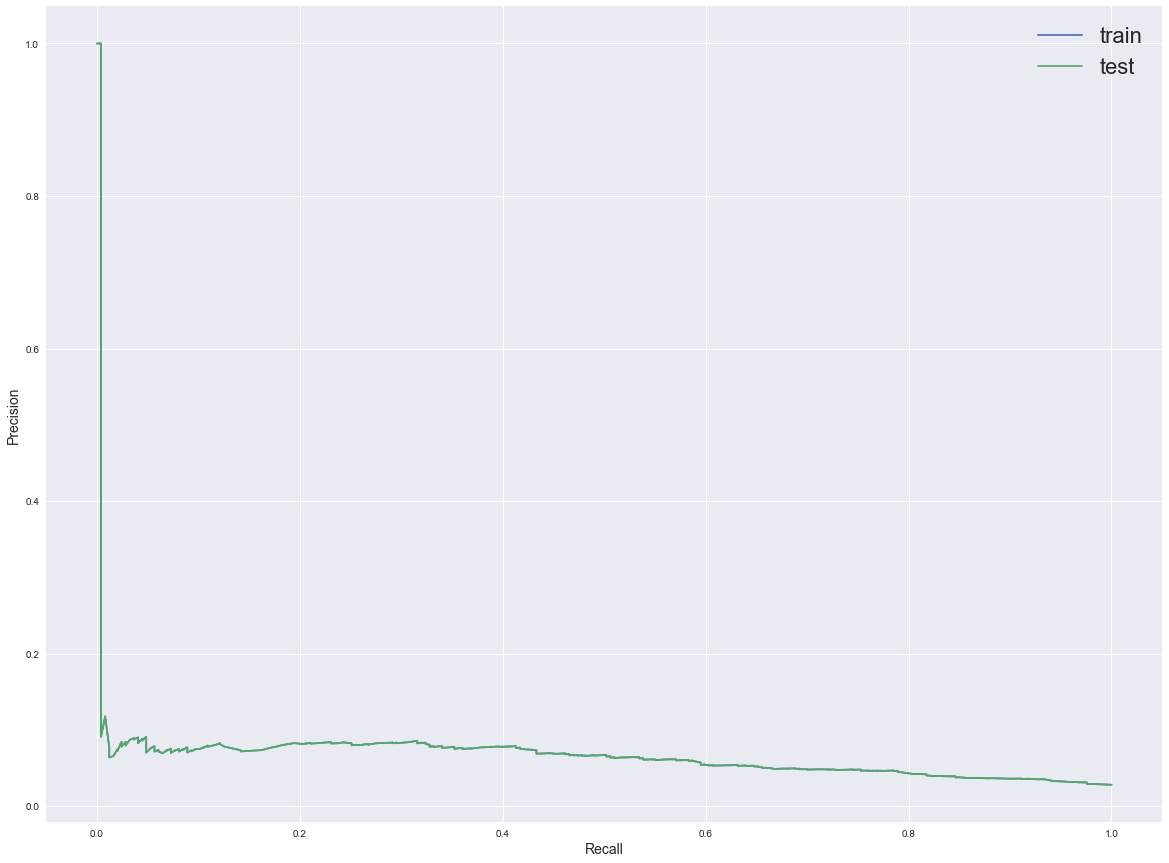

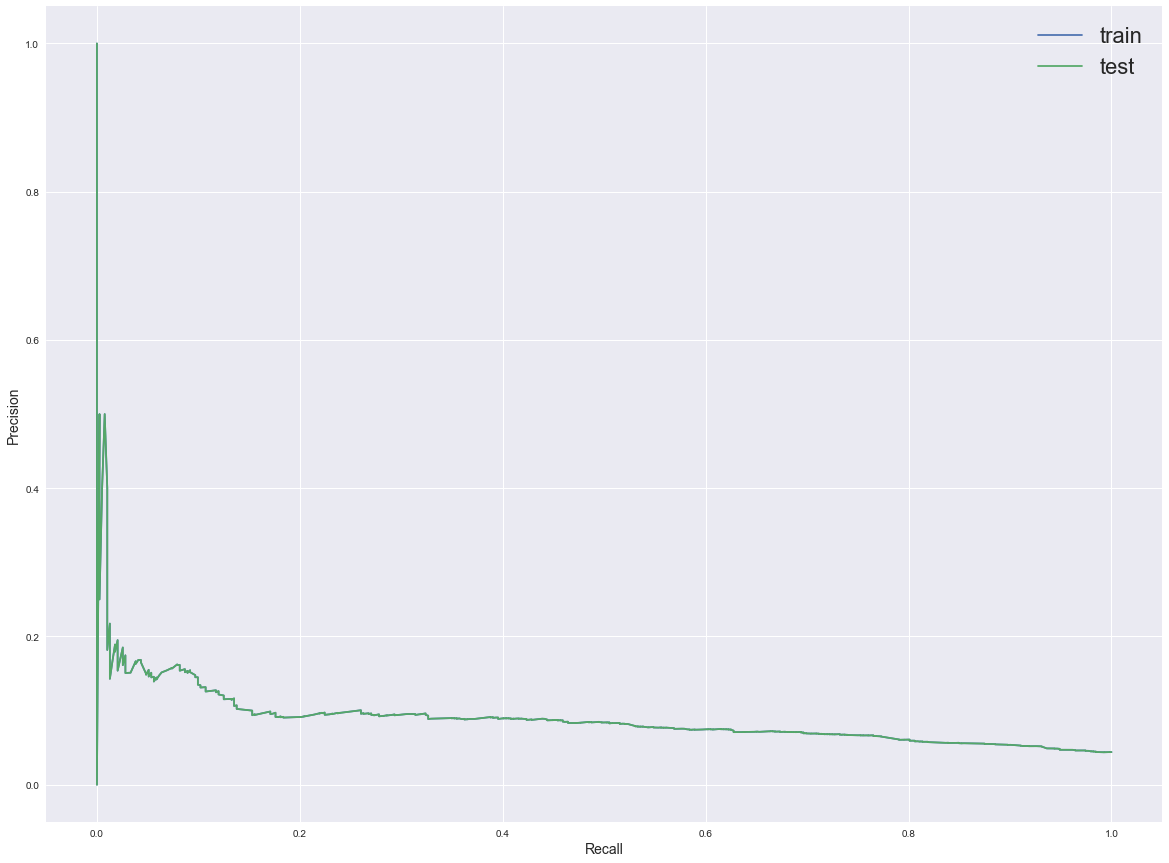

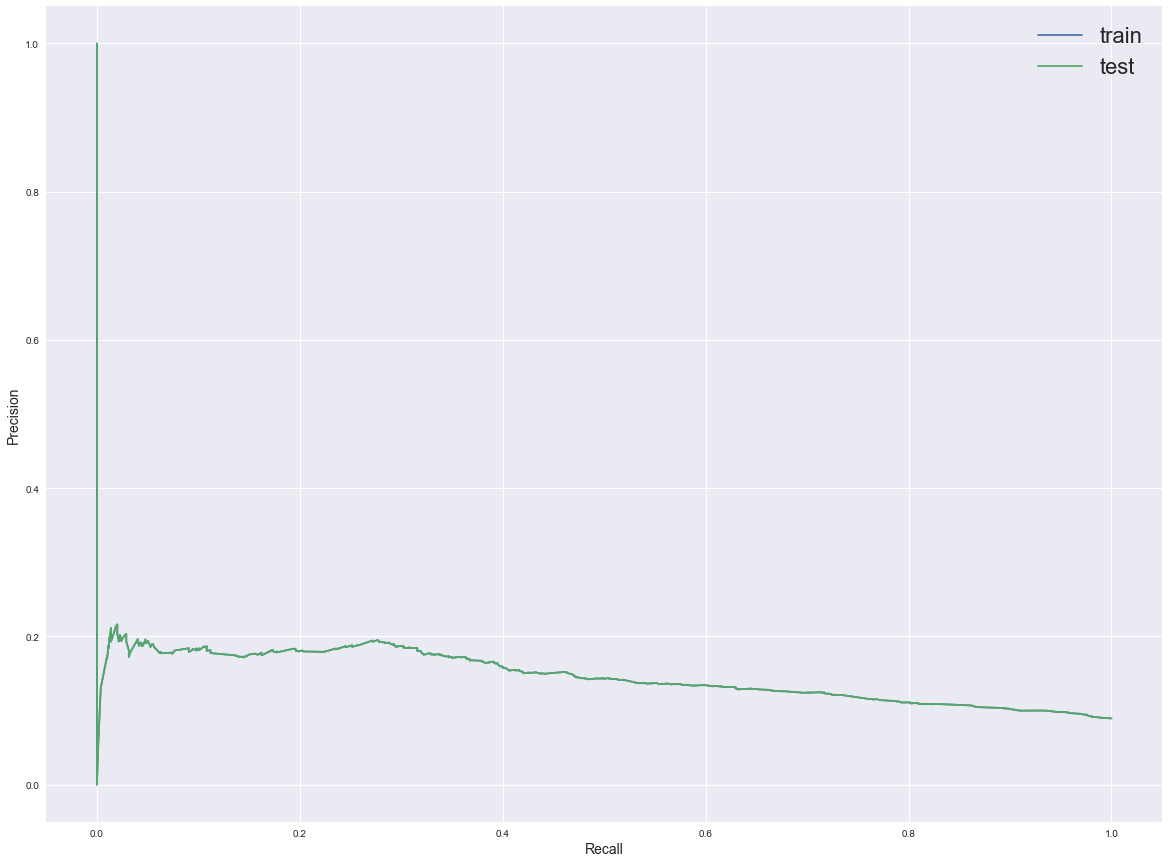

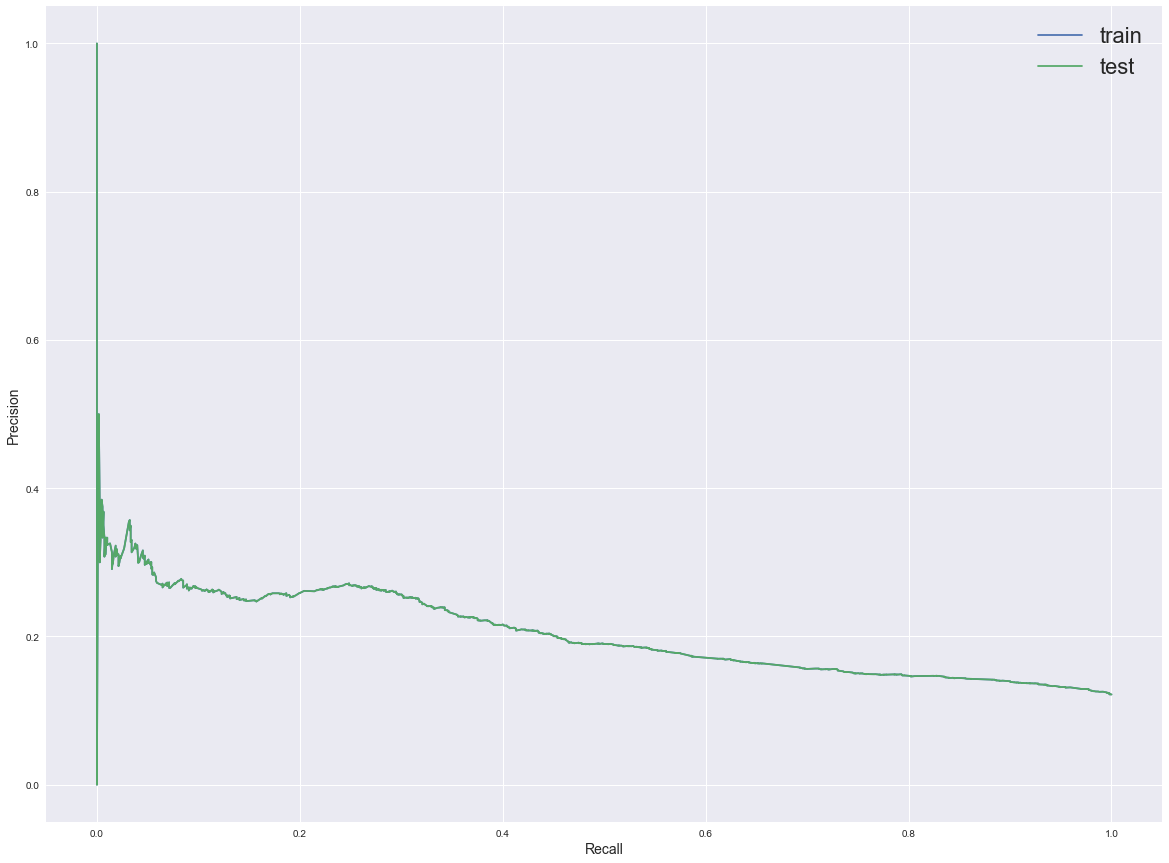

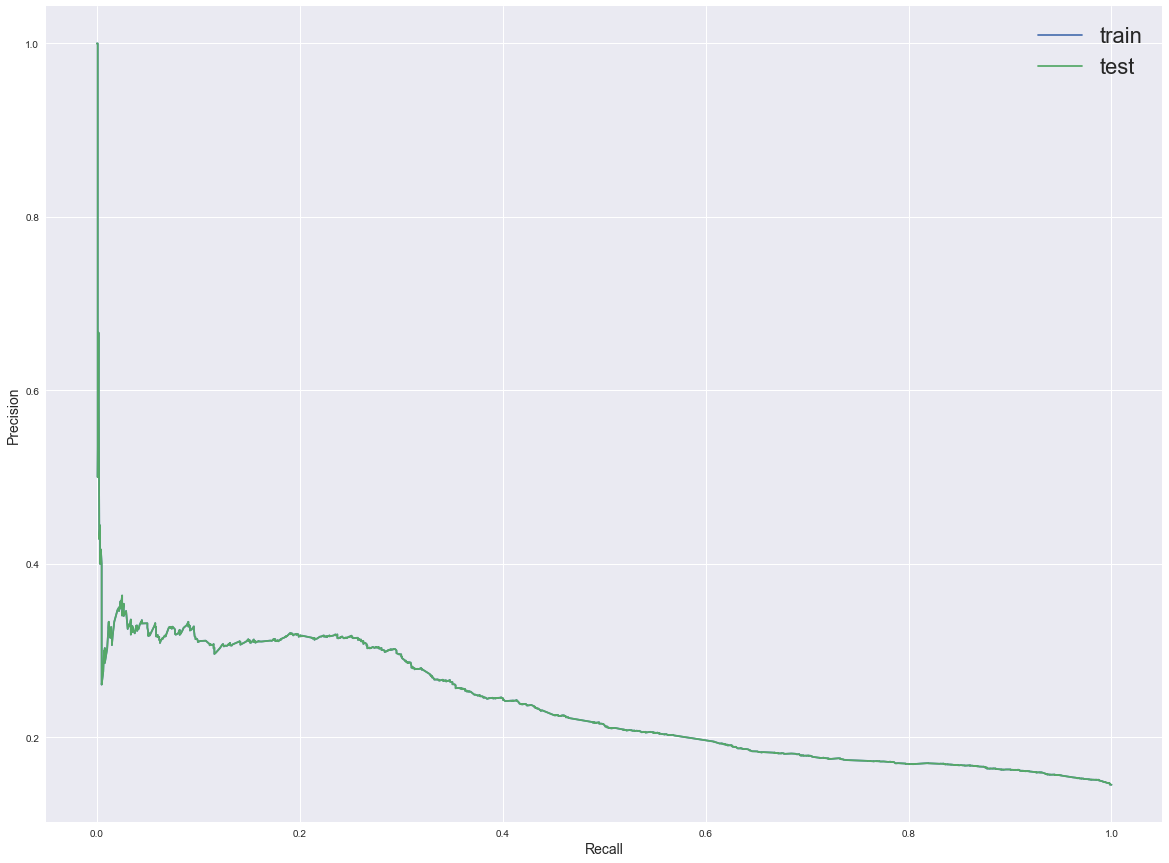

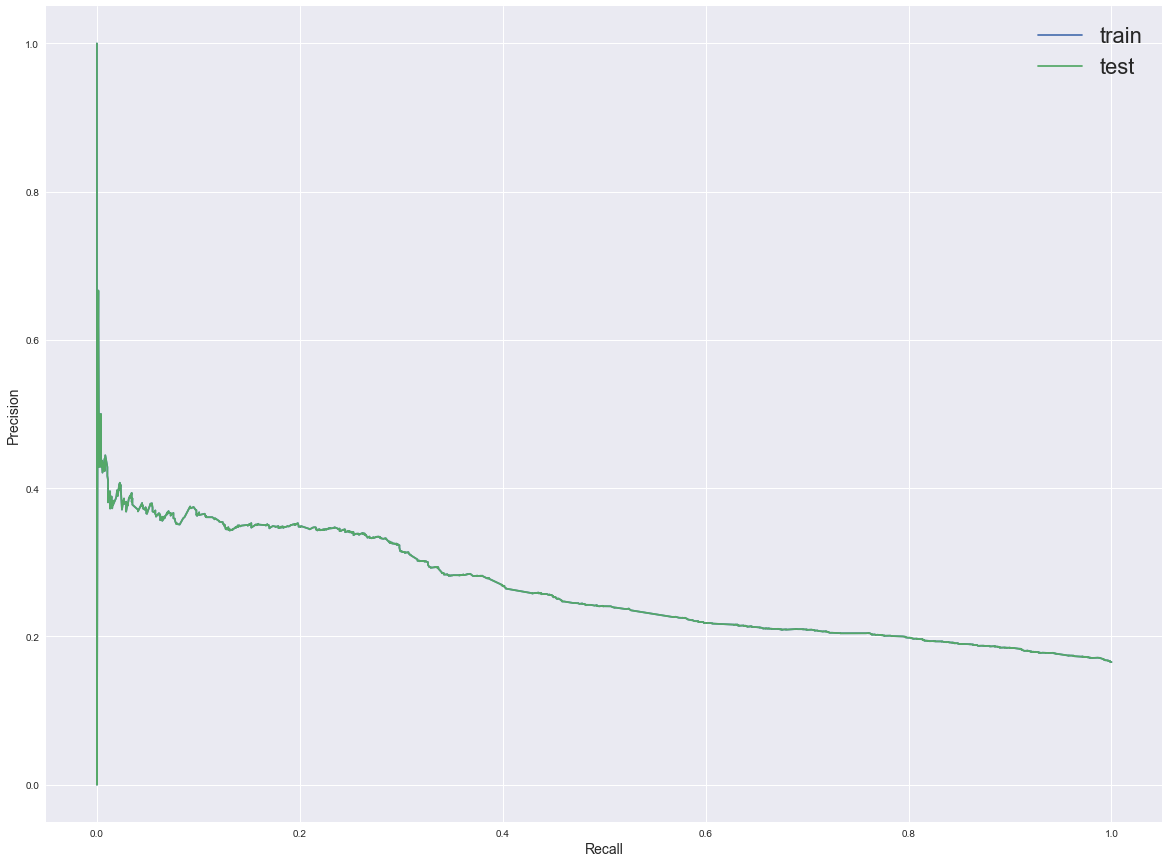

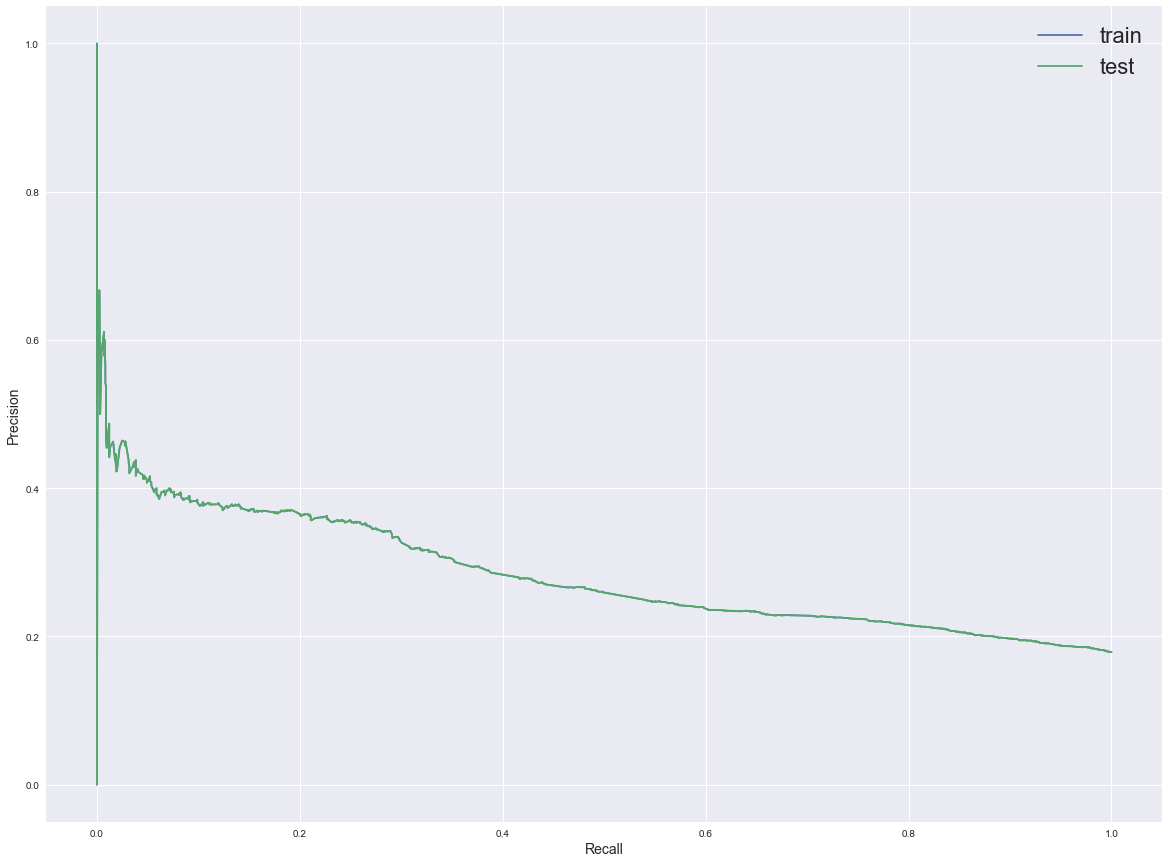

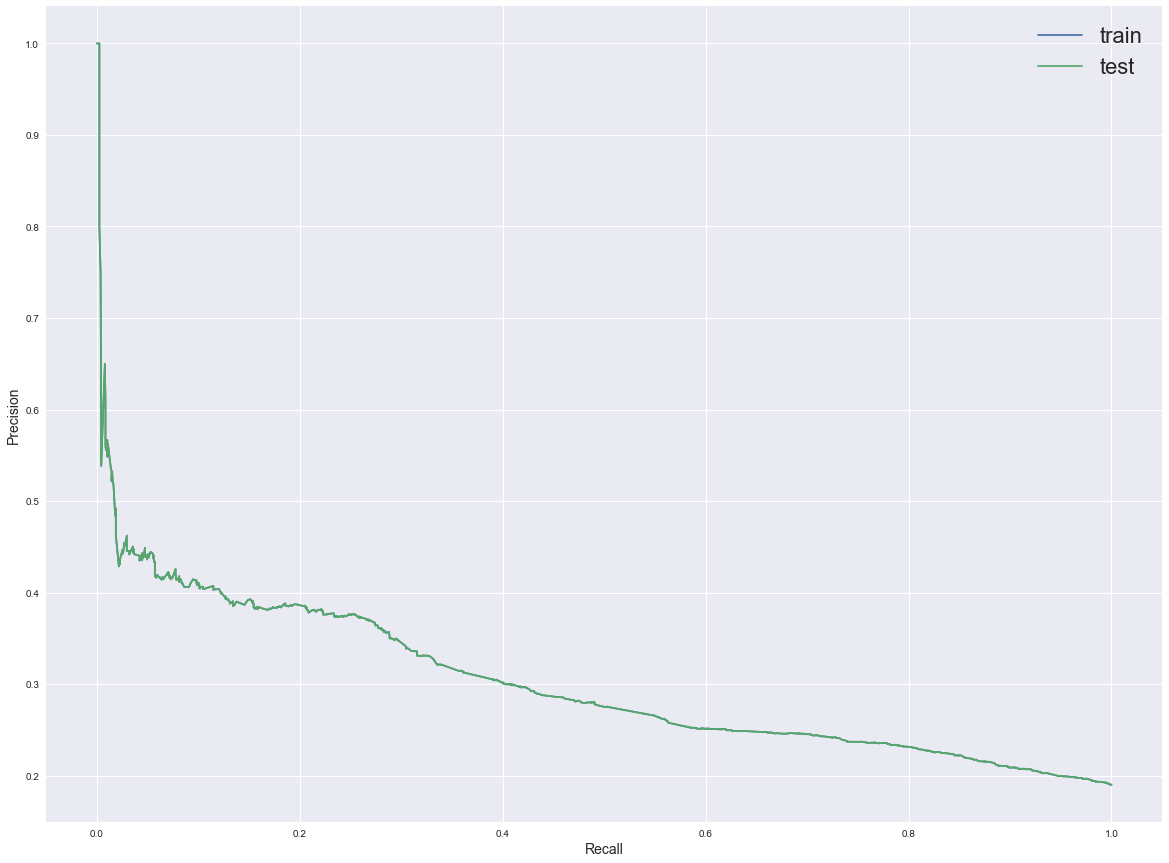

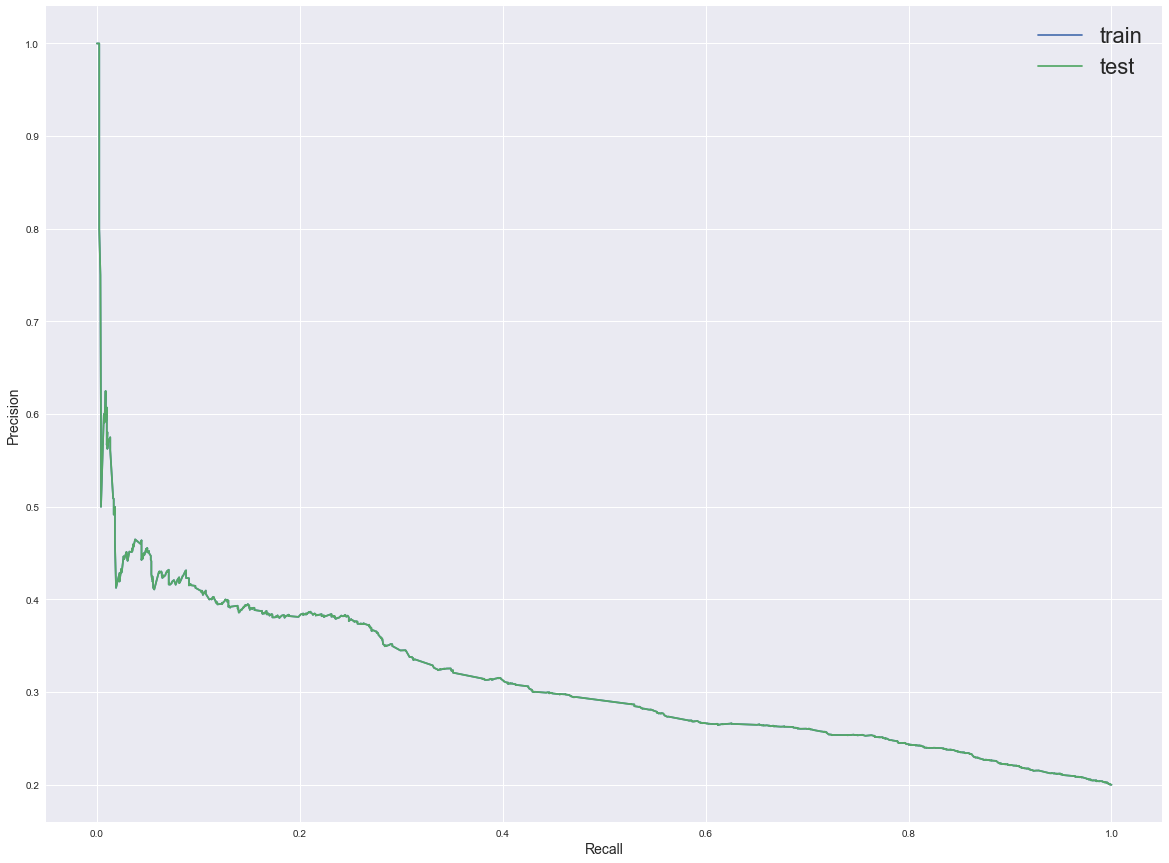

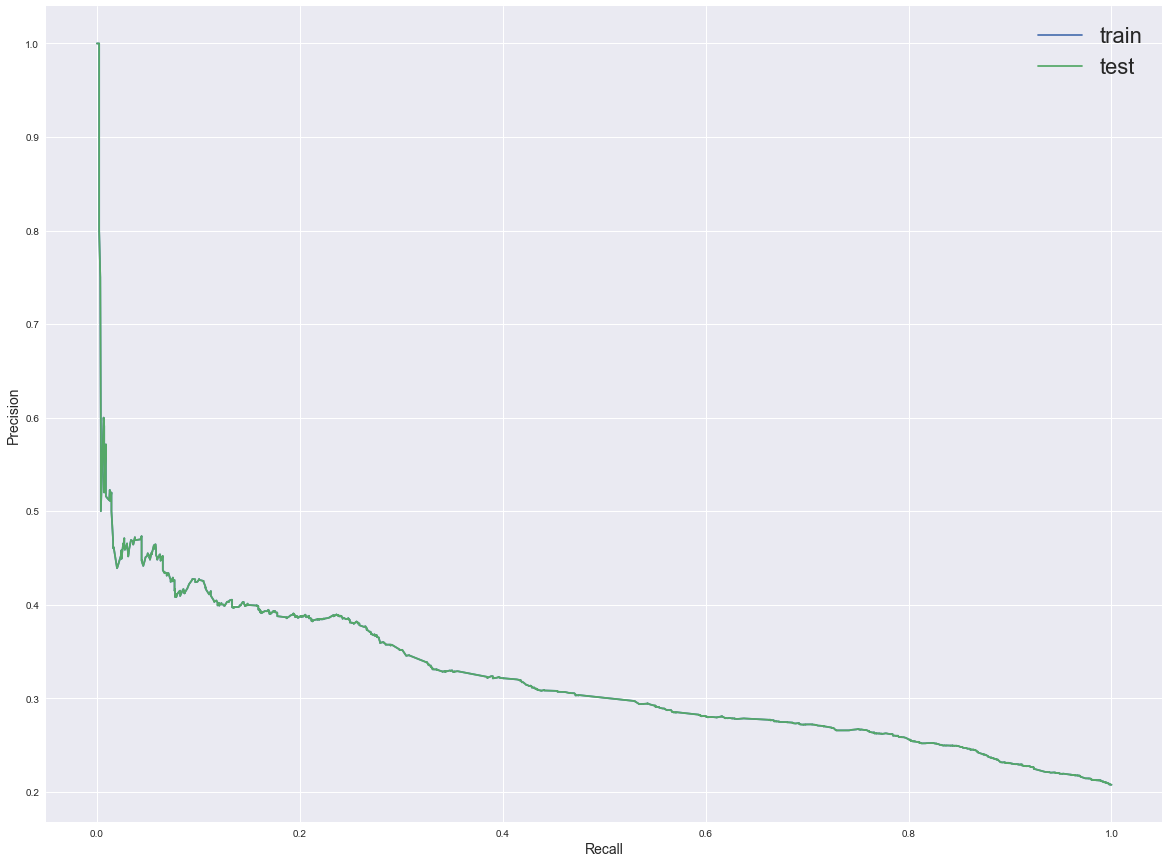

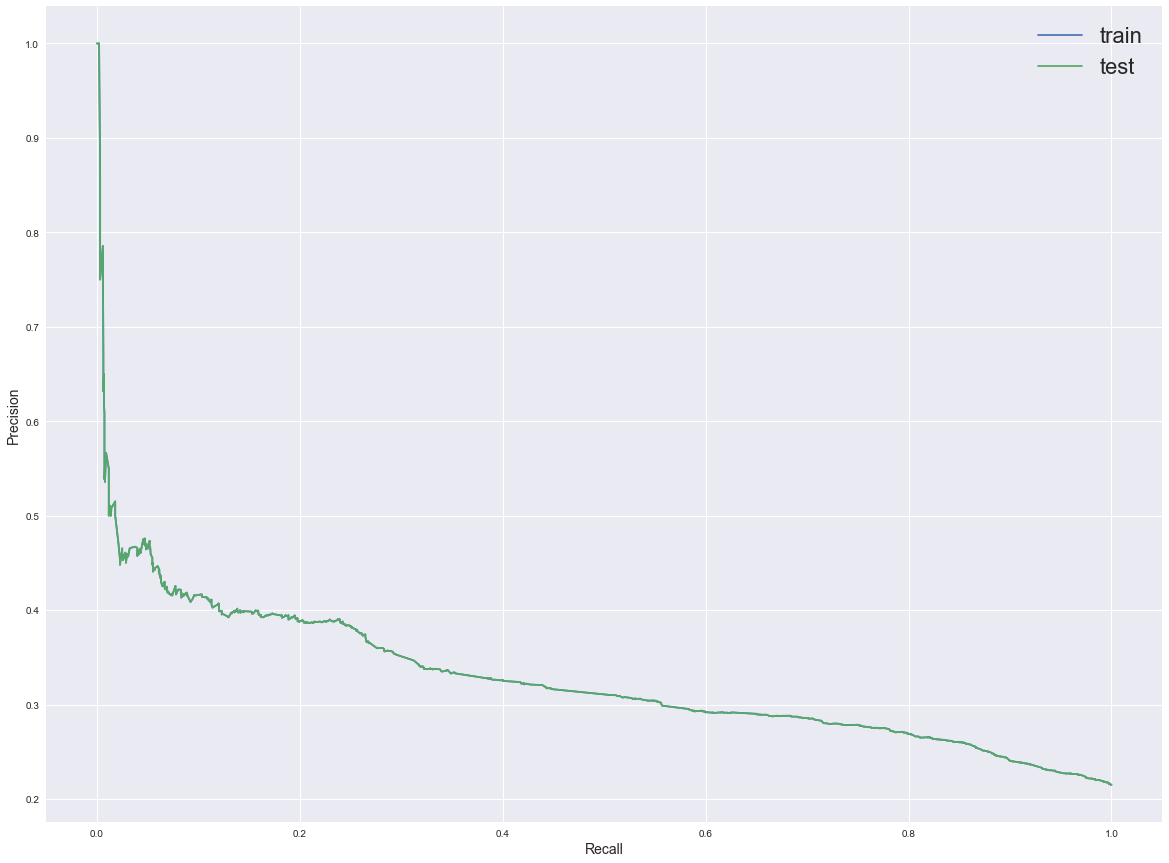

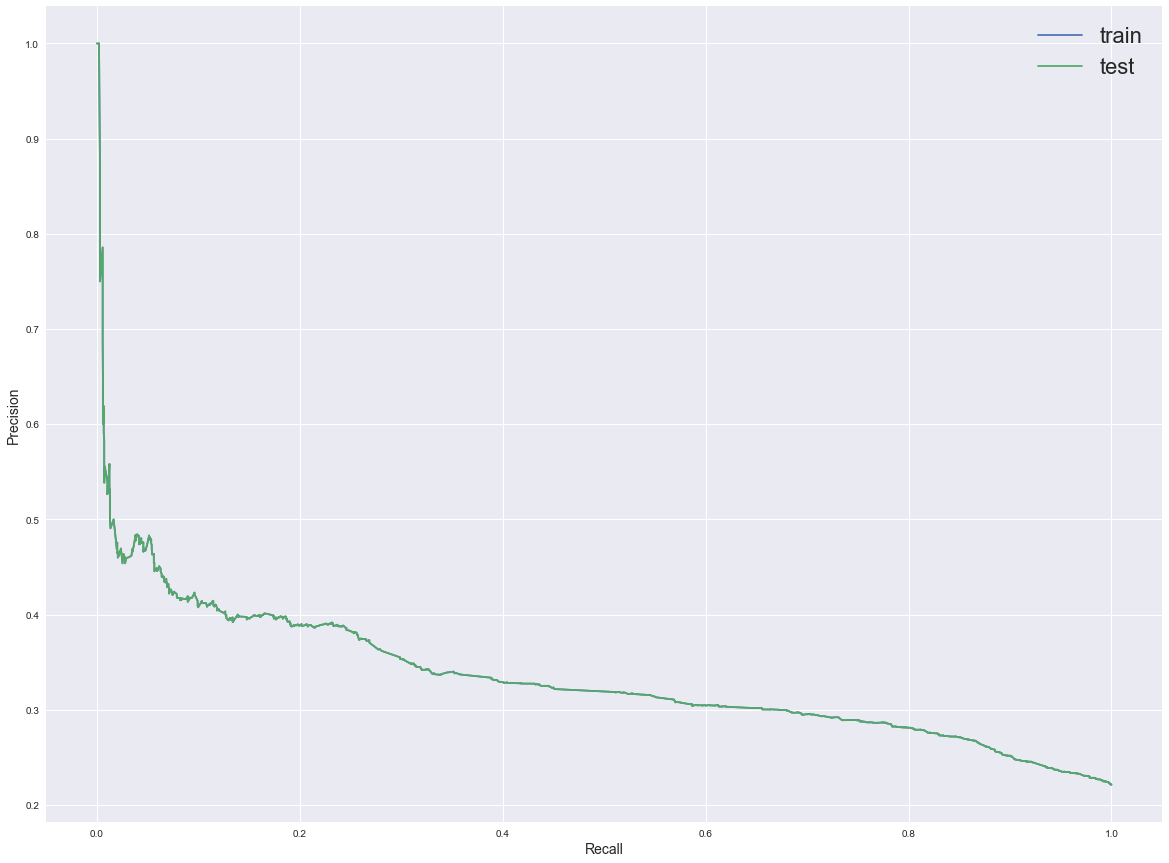

In [52]:

for category in label_cols:
    print('**Processing {} comments...**'.format(category))
    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    logistic_hyper_params = logistic_hyper_params(param_grid, X_train, y_train[category], X_test, y_test[category])
    lr = logistic_hyper_params.best_estimator_
    lr.fit(X_train, y_train[category])
    
    prediction = lr.predict_proba(X_test)[:, 1]
    classes = lr.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], classes)))
    print('Test AUC is {}'.format(AUC(y_test[category], prediction)))
    print('Test Calibration Ratio: {}'.format(np.sum(y_test[category]) / np.sum(prediction)))
    precision_recall_train = precision_recall_curve(y_test[category], prediction)
    precision_recall_test = precision_recall_curve(y_test[category], prediction)
    plt.figure(figsize=(20,15))
    plt.plot(precision_recall_train[1], precision_recall_train[0], label='train')
    plt.plot(precision_recall_test[1], precision_recall_test[0], label='test')
    plt.legend(fontsize=22)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('{} - Average Precision : {}'.format(category,average_precision_score(y_test[category], prediction)), fontsize=18)
    print("\n")